#0. O notebook está estruturado em:

1. Estatística descritiva da idade dos participantes;

2. Dispersão do *corpora* e realização de LDA das tags e subtags levantadas pelo requalify.ai

3. Treinamento de modelo de linguagem;

4. Utilização do modelo afinado para descobrir os temas de cada grupo

5. Redução de dimensionalidade das tags e subtags.



#1. Idade das participantes

In [ ]:
import numpy as np

idades = [57, 68, 60, 59, 55, 53, 53, 50, 50, 49, 49, 48, 48, 48, 47, 46, 46, 45, 44, 44, 43, 43, 41, 39, 38, 38, 32, 32, 32, 27]
media = np.mean(idades)
desvio_padrao = np.std(idades)

print(f"Média {media:.2f} (DP = {desvio_padrao:.2f})")


Média 46.13 (DP = 8.92)


_______
#2.0. Gráfico de dispersão do *corpora* feita pelo Voyant Tools



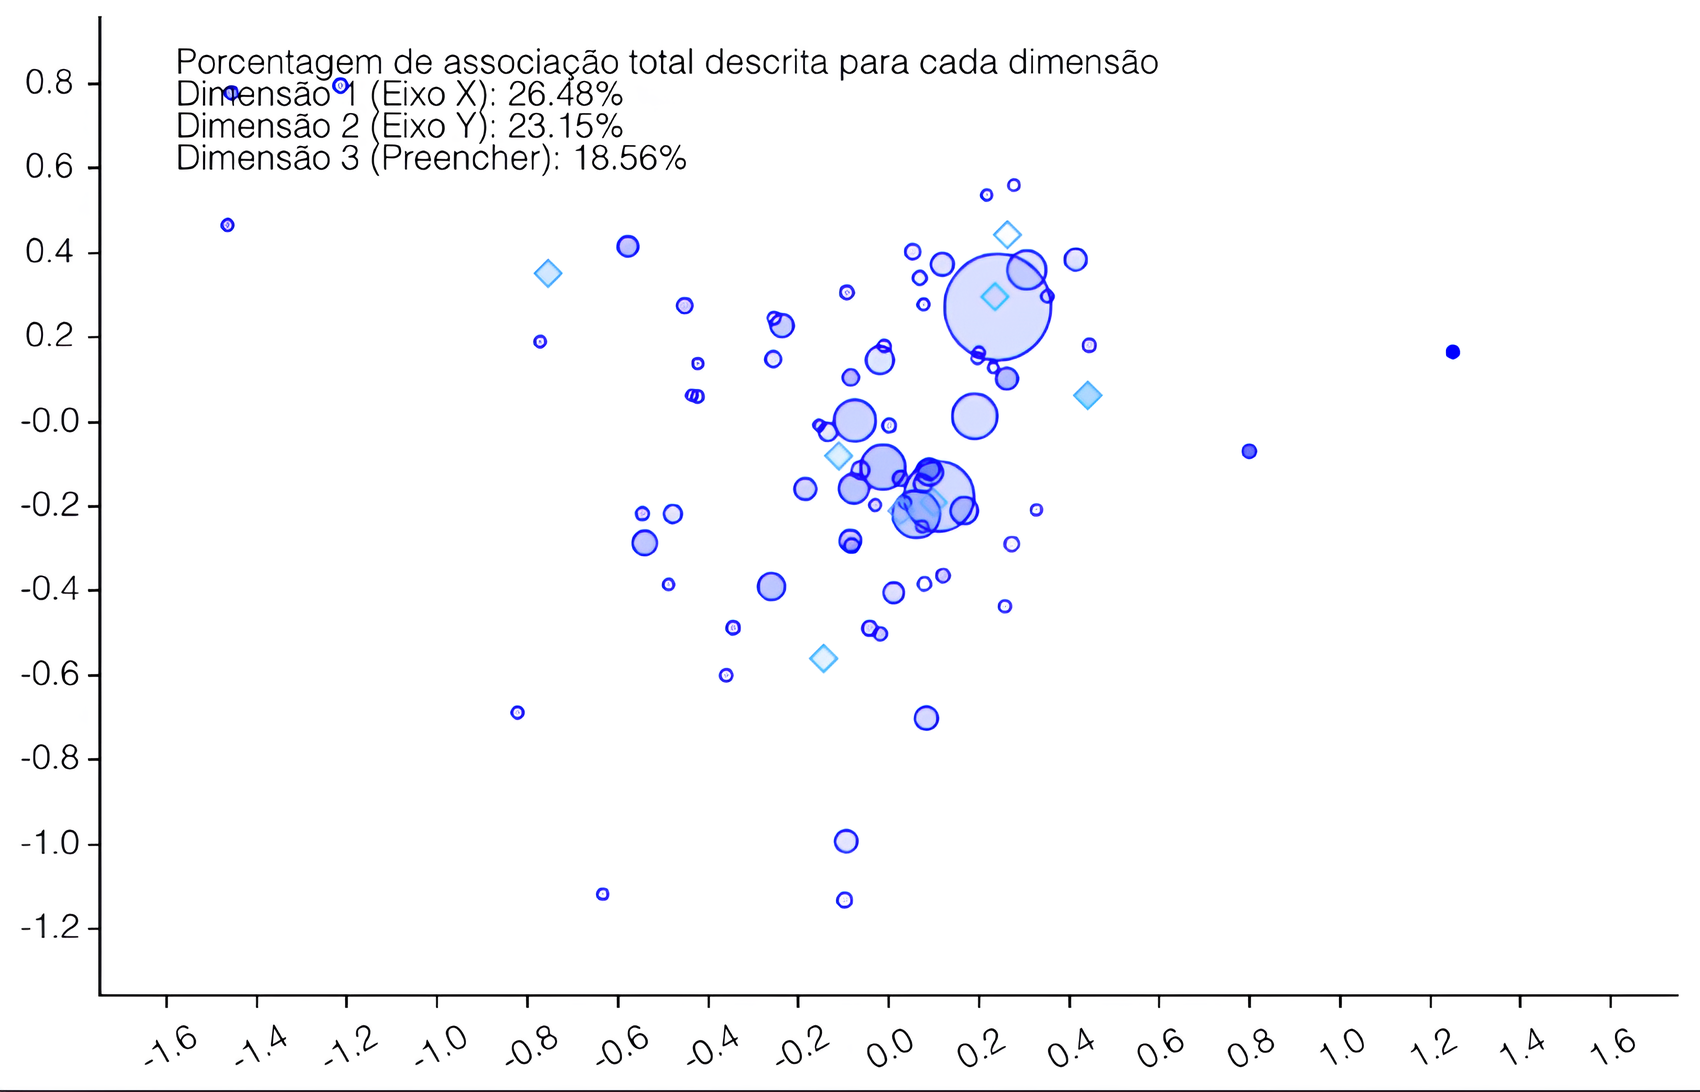

Os temas estão muito aglutinados. Uma saída foi realizar levantamento de tags e subtags pelo requalify.ai. Conteúdo do arquivo resultados tópicos com palavras 3.xlsx

#2.1. LDA das tags e subtags levantadas pelo requalify.ai

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk
from nltk.corpus import stopwords

# Carrega stopwords em português
nltk.download('stopwords')

# Carrega o arquivo Excel
file_path = "resultados_tópicos_com_palavras2.xlsx"
sheet_name = "Planilha1"
df = pd.read_excel(file_path, sheet_name=sheet_name)

# Seleciona a coluna de descrições
descriptions = df['Description'].dropna()

# Pré-processa do texto com stopwords em português
stop_words_pt = stopwords.words('portuguese')  # Lista de stopwords em português
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words=stop_words_pt)
X = vectorizer.fit_transform(descriptions)

# Aplica LDA para modelagem por tópicos
num_topics = len(descriptions)  # Um tópico por descrição
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(X)

# Extrai as palavras mais importantes por tópico
feature_names = vectorizer.get_feature_names_out()
top_words_per_topic = []

for topic_idx, topic in enumerate(lda_model.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-11:-1]]  # Top 10 palavras por tópico
    top_words_per_topic.append(", ".join(top_words))

# Adiciona as palavras mais importantes como nova coluna no DataFrame
df['Tópico Principal'] = top_words_per_topic

# Salva os resultados em um novo arquivo Excel (opcional)
output_path = "resultados_tópicos_com_palavras3.xlsx"
df.to_excel(output_path, index=False)
print(f"Resultados salvos em: {output_path}")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Resultados salvos em: resultados_tópicos_com_palavras3.xlsx


_____
#3. Treinamento do modelo Meta-llama 3.1 7b

### Verificar as stopwords

In [ ]:
# Baixa as stopwords do NLTK
nltk.download('stopwords')

# Obtem a lista de stopwords em português
stop_words_pt = stopwords.words('portuguese')

print("Stopwords em Português:")
print(stop_words_pt)

Stopwords em Português:
['a', 'à', 'ao', 'aos', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aquilo', 'as', 'às', 'até', 'com', 'como', 'da', 'das', 'de', 'dela', 'delas', 'dele', 'deles', 'depois', 'do', 'dos', 'e', 'é', 'ela', 'elas', 'ele', 'eles', 'em', 'entre', 'era', 'eram', 'éramos', 'essa', 'essas', 'esse', 'esses', 'esta', 'está', 'estamos', 'estão', 'estar', 'estas', 'estava', 'estavam', 'estávamos', 'este', 'esteja', 'estejam', 'estejamos', 'estes', 'esteve', 'estive', 'estivemos', 'estiver', 'estivera', 'estiveram', 'estivéramos', 'estiverem', 'estivermos', 'estivesse', 'estivessem', 'estivéssemos', 'estou', 'eu', 'foi', 'fomos', 'for', 'fora', 'foram', 'fôramos', 'forem', 'formos', 'fosse', 'fossem', 'fôssemos', 'fui', 'há', 'haja', 'hajam', 'hajamos', 'hão', 'havemos', 'haver', 'hei', 'houve', 'houvemos', 'houver', 'houvera', 'houverá', 'houveram', 'houvéramos', 'houverão', 'houverei', 'houverem', 'houveremos', 'houveria', 'houveriam', 'houveríamos', 'houvermos', 'houvesse'

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%capture
# Installs Unsloth, Xformers (Flash Attention) and all other packages!
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps "xformers" "trl<0.9.0" peft accelerate bitsandbytes

In [ ]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/mistral-7b-v0.3-bnb-4bit",      # New Mistral v3 2x faster!
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/llama-3-8b-bnb-4bit",           # Llama-3 15 trillion tokens model 2x faster!
    "unsloth/llama-3-8b-Instruct-bnb-4bit",
    "unsloth/llama-3-70b-bnb-4bit",
    "unsloth/Phi-3-mini-4k-instruct",        # Phi-3 2x faster!
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/mistral-7b-bnb-4bit",
    "unsloth/gemma-7b-bnb-4bit",             # Gemma 2.2x faster!
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Meta-Llama-3.1-8B",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2024.12.12: Fast Llama patching. Transformers: 4.47.1.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 7.5. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2024.12.12 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


### Preparação dos dados

In [ ]:
import pandas as pd
import json

# Carrega o arquivo Excel
file_path = "/content/drive/MyDrive/UFMG/Alice/resultados_tópicos_com_palavras3.xlsx"
df = pd.read_excel(file_path)

# Cria a estrutura JSON
data = []
for _, row in df.iterrows():
    topic = row['Topic']
    description = row['Description']
    terms = row['Terms'].split(", ")  # Separar as palavras-chave

    entry = {
        "instruction": (
            "Analise as palavras fornecidas e dê o nome aos tópicos, interpretando o significado "
            "principal de cada grupo de palavras considerando que se trata de uma transcrição "
            "de grupos de musicoterapia com mulheres negras."
        ),
        "input": f"Aqui estão as palavras: {terms}.",
        "output": f"{topic}. Descrição: {description}"
    }
    data.append(entry)

# Salva como JSON
output_path = "topicos_musicoterapia.json"
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(data, f, ensure_ascii=False, indent=4)

print(f"Arquivo JSON salvo em: {output_path}")


Arquivo JSON salvo em: topicos_musicoterapia.json


In [ ]:
dados_personalizados = True

if dados_personalizados:
  alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

  ### Instruction:
  {}



  ### Response:
  {}"""

  EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
  def formatting_prompts_func(examples):
      instructions = examples["input"]
      #inputs       = examples["input"]
      outputs      = examples["output"]
      texts = []
      for instruction, output in zip(instructions, outputs):
          # Must add EOS_TOKEN, otherwise your generation will go on forever!
          text = alpaca_prompt.format(instruction, output) + EOS_TOKEN
          texts.append(text)
      return { "text" : texts, }
  pass

  from datasets import load_dataset
  dataset = load_dataset("json", data_files="topicos_musicoterapia.json", split = "train")
  dataset = dataset.map(formatting_prompts_func, batched = True,)

else:
  from datasets import load_dataset
  dataset = load_dataset("vicgalle/alpaca-gpt4", split = "train")
  print(dataset.column_names)

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/169 [00:00<?, ? examples/s]

In [ ]:
print(dataset.column_names)

['instruction', 'input', 'output', 'text']


In [ ]:
from unsloth import to_sharegpt
dataset = to_sharegpt(
    dataset,
    merged_prompt = "{instruction}[[\nYour input is:\n{input}]]",
    output_column_name = "output",
    conversation_extension = 3,
)

In [ ]:
from unsloth import standardize_sharegpt
dataset = standardize_sharegpt(dataset)

Standardizing format:   0%|          | 0/169 [00:00<?, ? examples/s]

In [ ]:
alpaca_prompt = """Abaixo estão algumas instruções que descrevem tarefas. Escreva respostas que completem adequadamente cada solicitação.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

In [ ]:
chat_template = """Abaixo estão algumas instruções que descrevem tarefas. Escreva respostas que completem adequadamente cada solicitação.

### Instruction:
{INPUT}

### Response:
{OUTPUT}"""

from unsloth import apply_chat_template

# Personalize o default_system_message para um comportamento de chatbot
default_system_message = (
    "Você é um assistente empático e conhecedor, treinado para analisar e interpretar tópicos "
    "de sessões de musicoterapia com mulheres negras. Seu objetivo é fornecer respostas perspicazes "
    "e contextualmente apropriadas."
)

dataset = apply_chat_template(
    dataset,
    tokenizer=tokenizer,
    chat_template=chat_template,
    default_system_message=default_system_message  # Adicionando a mensagem personalizada
)


Unsloth: We automatically added an EOS token to stop endless generations.


Map:   0%|          | 0/169 [00:00<?, ? examples/s]

In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 60,
        #num_train_epochs = 60, # For longer training runs!
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
    ),
)

Map (num_proc=2):   0%|          | 0/169 [00:00<?, ? examples/s]

In [ ]:
#@title Mostrar o status da memória
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.748 GB.
6.004 GB of memory reserved.


###Treinamento

In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 169 | Num Epochs = 3
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 60
 "-____-"     Number of trainable parameters = 41,943,040
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss
1,1.514000
2,1.538900
3,1.478500
4,1.495000
5,1.356700
6,1.212900
7,1.108800
8,1.023400
9,0.933200
10,0.751800


In [ ]:
#@title Mostrar a memória final e o status da memória
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

1070.7159 seconds used for training.
17.85 minutes used for training.
Peak reserved memory = 8.029 GB.
Peak reserved memory for training = 2.025 GB.
Peak reserved memory % of max memory = 54.441 %.
Peak reserved memory for training % of max memory = 13.731 %.


In [ ]:
import shutil
output_dir = "/content/drive/MyDrive/UFMG/Alice/modelo_afinado"

# Salva o modelo no formato Hugging Face
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Compacta a pasta para economizar espaço
shutil.make_archive(output_dir, 'zip', output_dir)

print(f"Modelo salvo e compactado em: {output_dir}.zip")

Modelo salvo e compactado em: /content/drive/MyDrive/UFMG/Alice/modelo_afinado.zip


### Salvamento do modelo em armazenamento local

In [ ]:
# Save to 8bit Q8_0
if True: model.save_pretrained_gguf("model", tokenizer,)
# Remember to go to https://huggingface.co/settings/tokens for a token!
# And change hf to your username!
if False: model.push_to_hub_gguf("hf/model", tokenizer, token = "")

# Save to 16bit GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "f16")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "f16", token = "")

# Save to q4_k_m GGUF
if False: model.save_pretrained_gguf("modelQ4", tokenizer, quantization_method = "q4_k_m")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "q4_k_m", token = "")

# Save to multiple GGUF options - much faster if you want multiple!
if False:
    model.push_to_hub_gguf(
        "hf/model", # Change hf to your username!
        tokenizer,
        quantization_method = ["q4_k_m", "q8_0", "q5_k_m",],
        token = "", # Get a token at https://huggingface.co/settings/tokens
    )

Unsloth: ##### The current model auto adds a BOS token.
Unsloth: ##### Your chat template has a BOS token. We shall remove it temporarily.
Unsloth: You have 1 CPUs. Using `safe_serialization` is 10x slower.
We shall switch to Pytorch saving, which might take 3 minutes and not 30 minutes.
To force `safe_serialization`, set it to `None` instead.
Unsloth: Kaggle/Colab has limited disk space. We need to delete the downloaded
model which will save 4-16GB of disk space, allowing you to save on Kaggle/Colab.
Unsloth: Will remove a cached repo with size 5.7G


Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 5.19 out of 12.67 RAM for saving.
Unsloth: Saving model... This might take 5 minutes ...


 44%|████▍     | 14/32 [00:01<00:01, 11.12it/s]
We will save to Disk and not RAM now.
100%|██████████| 32/32 [01:44<00:00,  3.28s/it]


Unsloth: Saving tokenizer... Done.
Unsloth: Saving model/pytorch_model-00001-of-00004.bin...
Unsloth: Saving model/pytorch_model-00002-of-00004.bin...
Unsloth: Saving model/pytorch_model-00003-of-00004.bin...
Unsloth: Saving model/pytorch_model-00004-of-00004.bin...
Done.


Unsloth: Converting llama model. Can use fast conversion = False.


==((====))==  Unsloth: Conversion from QLoRA to GGUF information
   \\   /|    [0] Installing llama.cpp might take 3 minutes.
O^O/ \_/ \    [1] Converting HF to GGUF 16bits might take 3 minutes.
\        /    [2] Converting GGUF 16bits to ['q8_0'] might take 10 minutes each.
 "-____-"     In total, you will have to wait at least 16 minutes.

Unsloth: Installing llama.cpp. This might take 3 minutes...
Unsloth: CMAKE detected. Finalizing some steps for installation.
Unsloth: [1] Converting model at model into q8_0 GGUF format.
The output location will be /content/model/unsloth.Q8_0.gguf
This might take 3 minutes...
INFO:hf-to-gguf:Loading model: model
INFO:gguf.gguf_writer:gguf: This GGUF file is for Little Endian only
INFO:hf-to-gguf:Exporting model...
INFO:hf-to-gguf:rope_freqs.weight,           torch.float32 --> F32, shape = {64}
INFO:hf-to-gguf:gguf: loading model weight map from 'pytorch_model.bin.index.json'
INFO:hf-to-gguf:gguf: loading model part 'pytorch_model-00001-of-00004.bin

Unsloth: ##### The current model auto adds a BOS token.
Unsloth: ##### We removed it in GGUF's chat template for you.


Unsloth: Conversion completed! Output location: /content/model/unsloth.Q8_0.gguf
Unsloth: Saved Ollama Modelfile to model/Modelfile


In [ ]:
import torch
print(torch.cuda.is_available())

True


____
#4. Utilização do modelo afinado para descobrir os temas de cada grupo

É necessário que o modelo seja chamado com uso do float16.

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# Caminho do modelo salvo
model_dir = "/content/drive/MyDrive/UFMG/Alice/modelo_afinado"

# Carregar o modelo com float16
model = AutoModelForCausalLM.from_pretrained(
    model_dir,
    device_map="auto",
    torch_dtype=torch.float16  # Força o uso de float16
)

tokenizer = AutoTokenizer.from_pretrained(model_dir)

print("Modelo carregado com float16!")

Modelo carregado com float16!


In [ ]:
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install transformers==4.47.1 torch==2.5.1

  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-sye5ybii/unsloth_abb87a7a617d45969f00a4dfb0571ed3
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-sye5ybii/unsloth_abb87a7a617d45969f00a4dfb0571ed3
  Resolved https://github.com/unslothai/unsloth.git to commit 7accbe89914be05b7de653943918f12527d213d6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 85.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 80.1 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.13.3
    Uninstalling tokenizers-0.13.3:
      Successfully uninstalled tokenizers-0.13.3
  Attempting uninstall: transformers
    Found existing installation: t

##Grupo 1 - Tópico 1


In [ ]:
from transformers import TextStreamer, DynamicCache
from unsloth import FastLanguageModel

# Configuração para usar ou não o chat template
com_chat_template = True

if com_chat_template:
    # Ativa inferência otimizada
    FastLanguageModel.for_inference(model)  # Ativa inferência 2x mais rápida

    # Mensagens no formato de chat
    messages = [
        {"role": "user", "content": "Analise as palavras fornecidas e dê o nome ao tópico, interpretando o significado principal do grupo de palavras considerando que se trata de uma transcrição de grupos de musicoterapia com mulheres negras."}
    ]

    # Aplicar o chat template
    input_ids = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        return_tensors="pt",
    ).to("cuda")

    # Streamer para geração do texto
    text_streamer = TextStreamer(tokenizer, skip_prompt=True)

    # Inicializa cache dinâmico (nova API)
    past_key_values = DynamicCache()

    # Gera texto com cache dinâmico
    _ = model.generate(input_ids, streamer=text_streamer, max_new_tokens=128, pad_token_id=tokenizer.eos_token_id)

else:
    # Prompt no formato Alpaca
    FastLanguageModel.for_inference(model)  # Ativa inferência 2x mais rápida

    # Define o prompt Alpaca
    alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

    # Lista de palavras (tópicos)
    topic_words = "['então', 'só', 'falou', 'pessoas', 'acho', 'ia', 'fica', 'queria', 'difícil', 'vamos']"

    # Cria inputs para o modelo com base no prompt
    inputs = tokenizer(
        [
            alpaca_prompt.format(
                "Analise as palavras fornecidas e dê o nome aos tópicos, interpretando o significado principal de cada grupo de palavras considerando que se trata de uma transcrição de grupos de musicoterapia com mulheres negras.",  # Instruction
                f"Aqui estão as palavras: {topic_words}",  # Input
                "",  # Output vazio para geração!
            )
        ],
        return_tensors="pt",
        padding=True,
        truncation=True,
    ).to("cuda")

    # Adiciona explicitamente a máscara de atenção
    inputs["attention_mask"] = inputs["input_ids"] != tokenizer.pad_token_id

    # Streamer para geração do texto
    text_streamer = TextStreamer(tokenizer)

    # Inicializa cache dinâmico (nova API)
    past_key_values = DynamicCache()

    # Gera texto com cache dinâmico
    _ = model.generate(**inputs, streamer=text_streamer, max_new_tokens=128)


Experiência de Racismo e Preconceito. Descrição: O grupo relata situações de discriminação racial que enfrentou, tanto em espaços profissionais quanto em contextos sociais. Essas experiências são fundamentais para compreender a vivência das mulheres negras e a luta contra o racismo.<|end_of_text|>


##Grupo 1 - Tópico 2

In [ ]:
com_chat_template = True

if com_chat_template:
    FastLanguageModel.for_inference(model)

    messages = [
        {"role": "user", "content": "Analise as palavras fornecidas e dê o nome ao tópico, interpretando o significado principal do grupo de palavras considerando que se trata de uma transcrição de grupos de musicoterapia com mulheres negras."}
    ]

    input_ids = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        return_tensors="pt",
    ).to("cuda")

    text_streamer = TextStreamer(tokenizer, skip_prompt=True)

    past_key_values = DynamicCache()

    _ = model.generate(input_ids, streamer=text_streamer, max_new_tokens=128, pad_token_id=tokenizer.eos_token_id)

else:
    FastLanguageModel.for_inference(model)

    alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

    topic_words = "['vou', 'gente', 'falei', 'tinha', 'coisas', 'semana', 'fiquei', 'tava', 'trabalhar', 'saúde']"

    inputs = tokenizer(
        [
            alpaca_prompt.format(
                "Analise as palavras fornecidas e dê o nome aos tópicos, interpretando o significado principal de cada grupo de palavras considerando que se trata de uma transcrição de grupos de musicoterapia com mulheres negras.",  # Instruction
                f"Aqui estão as palavras: {topic_words}",
                "",
            )
        ],
        return_tensors="pt",
        padding=True,
        truncation=True,
    ).to("cuda")

    inputs["attention_mask"] = inputs["input_ids"] != tokenizer.pad_token_id

    text_streamer = TextStreamer(tokenizer)

    past_key_values = DynamicCache()

    _ = model.generate(**inputs, streamer=text_streamer, max_new_tokens=128)


Experiência de Racismo e Identidade. Descrição: As participantes compartilham experiências de racismo e como isso impacta sua autoimagem e identidade. Ela menciona como o preconceito a faz sentir que não é bonita, refletindo a intersecção entre racismo e gênero.<|end_of_text|>


## Grupo 1 - Tópico 3

In [ ]:
com_chat_template = True

if com_chat_template:
    FastLanguageModel.for_inference(model)

    messages = [
        {"role": "user", "content": "Analise as palavras fornecidas e dê o nome ao tópico, interpretando o significado principal do grupo de palavras considerando que se trata de uma transcrição de grupos de musicoterapia com mulheres negras."}
    ]

    input_ids = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        return_tensors="pt",
    ).to("cuda")

    text_streamer = TextStreamer(tokenizer, skip_prompt=True)

    past_key_values = DynamicCache()

    _ = model.generate(input_ids, streamer=text_streamer, max_new_tokens=128, pad_token_id=tokenizer.eos_token_id)

else:
    FastLanguageModel.for_inference(model)

    alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

    topic_words = "['gente', 'então', 'falar', 'música', 'só', 'tinha', 'fala', 'coisas', 'mãe', 'mesmo']"

    inputs = tokenizer(
        [
            alpaca_prompt.format(
                "Analise as palavras fornecidas e dê o nome aos tópicos, interpretando o significado principal de cada grupo de palavras considerando que se trata de uma transcrição de grupos de musicoterapia com mulheres negras.",  # Instruction
                f"Aqui estão as palavras: {topic_words}",
                "",
            )
        ],
        return_tensors="pt",
        padding=True,
        truncation=True,
    ).to("cuda")

    inputs["attention_mask"] = inputs["input_ids"] != tokenizer.pad_token_id

    text_streamer = TextStreamer(tokenizer)

    past_key_values = DynamicCache()

    _ = model.generate(**inputs, streamer=text_streamer, max_new_tokens=128)


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


A Música como Espaço de Conexão. Descrição: A música é apresentada como um elemento central nas sessões, servindo como um espaço de conexão e partilha entre as participantes. A música é usada para promover a reflexão sobre emoções e experiências, e também para criar um ambiente acolhedor onde as vozes podem ser ouvidas.<|end_of_text|>


##Grupo 2 - Tópico 1

In [ ]:
com_chat_template = True

if com_chat_template:

    FastLanguageModel.for_inference(model)

    messages = [
        {"role": "user", "content": "Analise as palavras fornecidas e dê o nome ao tópico, interpretando o significado principal do grupo de palavras considerando que se trata de uma transcrição de grupos de musicoterapia com mulheres negras."}
    ]

    input_ids = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        return_tensors="pt",
    ).to("cuda")

    text_streamer = TextStreamer(tokenizer, skip_prompt=True)

    past_key_values = DynamicCache()

    _ = model.generate(input_ids, streamer=text_streamer, max_new_tokens=128, pad_token_id=tokenizer.eos_token_id)

else:

    FastLanguageModel.for_inference(model)

    alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

    topic_words = "['música', 'falar', 'mulher', 'acho', 'mim', 'vida', 'ia', 'mesmo', 'dela', 'queria']"

    inputs = tokenizer(
        [
            alpaca_prompt.format(
                "Analise as palavras fornecidas e dê o nome aos tópicos, interpretando o significado principal de cada grupo de palavras considerando que se trata de uma transcrição de grupos de musicoterapia com mulheres negras.",  # Instruction
                f"Aqui estão as palavras: {topic_words}",
                "",
            )
        ],
        return_tensors="pt",
        padding=True,
        truncation=True,
    ).to("cuda")

    inputs["attention_mask"] = inputs["input_ids"] != tokenizer.pad_token_id

    text_streamer = TextStreamer(tokenizer)

    past_key_values = DynamicCache()

    _ = model.generate(**inputs, streamer=text_streamer, max_new_tokens=128)

A Importância da Expressão Através da Música. Descrição: A música é apresentada como uma forma de expressão e ressignificação das experiências dolorosas, permitindo que as participantes se conectem com suas emoções e histórias pessoais.<|end_of_text|>


##Grupo 2 - Tópico 2

In [ ]:
com_chat_template = True

if com_chat_template:

    FastLanguageModel.for_inference(model)

    messages = [
        {"role": "user", "content": "Analise as palavras fornecidas e dê o nome ao tópico, interpretando o significado principal do grupo de palavras considerando que se trata de uma transcrição de grupos de musicoterapia com mulheres negras."}
    ]

    input_ids = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        return_tensors="pt",
    ).to("cuda")

    text_streamer = TextStreamer(tokenizer, skip_prompt=True)

    past_key_values = DynamicCache()

    _ = model.generate(input_ids, streamer=text_streamer, max_new_tokens=128, pad_token_id=tokenizer.eos_token_id)

else:

    FastLanguageModel.for_inference(model)

    alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

    topic_words = "['vou', 'então', 'tinha', 'entendeu', 'dele', 'mulheres', 'fiquei', 'tocar', 'situação', 'vejo']"

    inputs = tokenizer(
        [
            alpaca_prompt.format(
                "Analise as palavras fornecidas e dê o nome aos tópicos, interpretando o significado principal de cada grupo de palavras considerando que se trata de uma transcrição de grupos de musicoterapia com mulheres negras.",  # Instruction
                f"Aqui estão as palavras: {topic_words}",
                "",
            )
        ],
        return_tensors="pt",
        padding=True,
        truncation=True,
    ).to("cuda")

    inputs["attention_mask"] = inputs["input_ids"] != tokenizer.pad_token_id

    text_streamer = TextStreamer(tokenizer)

    past_key_values = DynamicCache()

    _ = model.generate(**inputs, streamer=text_streamer, max_new_tokens=128)

Experiência de Racismo e Identidade. Descrição: O grupo relata sua experiência de racismo e como isso a afeta, refletindo sobre como as interseccções de gênero e raça impactam suas vivências. A música 'Eu Sou Nega' é mencionada como um grito de liberdade e identidade, mas também como um apelo para que as mulheres negras se reconheçam e valorizem suas histórias.<|end_of_text|>


##Grupo 2 - Tópico 3

In [ ]:
com_chat_template = True

if com_chat_template:

    FastLanguageModel.for_inference(model)

    messages = [
        {"role": "user", "content": "Analise as palavras fornecidas e dê o nome ao tópico, interpretando o significado principal do grupo de palavras considerando que se trata de uma transcrição de grupos de musicoterapia com mulheres negras."}
    ]

    input_ids = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        return_tensors="pt",
    ).to("cuda")

    text_streamer = TextStreamer(tokenizer, skip_prompt=True)

    past_key_values = DynamicCache()

    _ = model.generate(input_ids, streamer=text_streamer, max_new_tokens=128, pad_token_id=tokenizer.eos_token_id)

else:
    FastLanguageModel.for_inference(model)

    alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

    topic_words = "['gente', 'só', 'coisas', 'falei', 'fala', 'falou', 'então', 'pessoas', 'tava', 'ficar']"

    inputs = tokenizer(
        [
            alpaca_prompt.format(
                "Analise as palavras fornecidas e dê o nome aos tópicos, interpretando o significado principal de cada grupo de palavras considerando que se trata de uma transcrição de grupos de musicoterapia com mulheres negras.",  # Instruction
                f"Aqui estão as palavras: {topic_words}",
                "",
            )
        ],
        return_tensors="pt",
        padding=True,
        truncation=True,
    ).to("cuda")

    inputs["attention_mask"] = inputs["input_ids"] != tokenizer.pad_token_id

    text_streamer = TextStreamer(tokenizer)

    past_key_values = DynamicCache()

    _ = model.generate(**inputs, streamer=text_streamer, max_new_tokens=128)

A Importância da Comunidade. Descrição: O grupo enfatiza a relevância da comunidade e do apoio mútuo entre mulheres negras. Ela menciona a necessidade de criar espaços seguros para compartilhar experiências e fortalecer laços, ressaltando como a musicoterapia pode contribuir para esse processo.<|end_of_text|>


___

#5. Redução de dimensionalidade das tags

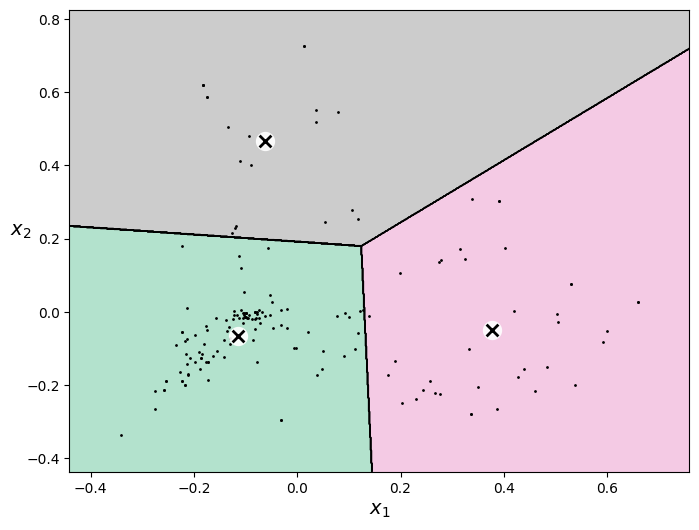

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Carrega os dados dos tópicos
file_path = file_path = "/content/drive/MyDrive/UFMG/Alice/resultados_tópicos_com_palavras3.xlsx"
df = pd.read_excel(file_path)

# Seleciona as colunas que contêm os tópicos completos
topics = df['Topic'].tolist()

# Vetoriza dos tópicos usando TF-IDF
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(topics)

# Aplica PCA para redução de dimensionalidade
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_tfidf.toarray())

# Utiliza o método KMeans++ para melhorar a posição dos centróides
kmeans_plus_plus = KMeans(n_clusters=3, init="k-means++", n_init=10, max_iter=300, random_state=42)
kmeans_plus_plus.fit(X_pca)

# Plota os dados
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

# Plota os centróides
def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

# Plota as fronteiras de decisão
def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

plt.figure(figsize=(8, 6))
plot_decision_boundaries(kmeans_plus_plus, X_pca)
plt.show()


In [ ]:
# Inicializa um dicionário para armazenar os escores de silhueta
silhouette_scores = {}
kmeans_per_k = {}

# Ajusta os modelos de KMeans para k entre 2 e 20 e calcular o coeficiente de silhueta
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)  # Ajusta o modelo
    score = silhouette_score(X_pca, kmeans.labels_)
    silhouette_scores[k] = score
    kmeans_per_k[k] = kmeans
    print(f"Coeficiente de Silhueta para k={k}: {round(score, 3)}")

Coeficiente de Silhueta para k=2: 0.494
Coeficiente de Silhueta para k=3: 0.588
Coeficiente de Silhueta para k=4: 0.544
Coeficiente de Silhueta para k=5: 0.467
Coeficiente de Silhueta para k=6: 0.488
Coeficiente de Silhueta para k=7: 0.459
Coeficiente de Silhueta para k=8: 0.505
Coeficiente de Silhueta para k=9: 0.473
Coeficiente de Silhueta para k=10: 0.473
Coeficiente de Silhueta para k=11: 0.488
Coeficiente de Silhueta para k=12: 0.472
Coeficiente de Silhueta para k=13: 0.468
Coeficiente de Silhueta para k=14: 0.48
Coeficiente de Silhueta para k=15: 0.498
Coeficiente de Silhueta para k=16: 0.517
Coeficiente de Silhueta para k=17: 0.52
Coeficiente de Silhueta para k=18: 0.528
Coeficiente de Silhueta para k=19: 0.524


#####O coeficiente com k = 3 é que possui o maior valor. A utilização de k = 3 foi adequada e classificou corretamente 97,65% dos dados.

In [ ]:
# Calcular os coeficientes de silhueta para o último valor de k
k = 3
kmeans = kmeans_per_k[k]
silhouette_coefficients = silhouette_samples(X_pca, kmeans.labels_)

# Contagem de quantos coeficientes de silhueta ficaram abaixo de 0, ou seja, erros de classificação para o último valor de k
classification_errors = np.sum(silhouette_coefficients < 0)
porcentagem = classification_errors / len(silhouette_coefficients)
print(f"Quantidade de erros de classificação: {classification_errors} ({porcentagem:.2%})")

Quantidade de erros de classificação: 4 (2.37%)


####Os textos agrupados em cada cluster foram:

In [ ]:
# Obter os rótulos dos clusters
cluster_labels = kmeans_plus_plus.labels_

# Adicionar os rótulos dos clusters ao DataFrame original
df['Cluster'] = cluster_labels

# Agrupar os temas por cluster
clusters = df.groupby('Cluster')['Topic'].apply(list)

# Exibir os temas em cada cluster
for cluster, topics in clusters.items():
    print(f"Cluster {cluster}:")
    for topic in topics:
        print(f" - {topic}")
    print("\n")

Cluster 0:
 - Criação Musical como Expressão Coletiva
 - Experiência de Discriminação e Militância
 - Saúde Mental e Autocuidado
 - Diversidade de Experiências e Identidade
 - Musicoterapia e Expressão Emocional
 - Solidão e Conexão
 - Autocuidado e Saúde Mental
 - Desafios da Identidade e Experiências Raciais
 - Resistência e Empoderamento
 - Experiência com Música e Saúde Mental
 - Identidade e Autoafirmação
 - Relação entre Música e Identidade
 - Desgaste emocional e militância
 - Experiência de discriminação racial
 - Diversidade de Experiências e Perspectivas
 - Desigualdade nas comissões e espaços de poder
 - Cuidado Pessoal e Limites
 - Saúde Mental e Acesso a Apoio
 - Experiência Coletiva e Aprendizado Comunitário
 - Desigualdade e Luta Pessoal
 - Identidade e Experiências Raciais
 - Coletividade e Compartilhamento de Experiências
 - Relação entre Saúde Mental e Identidade
 - Necessidade de Espaços de Escuta
 - Força nas Experiências Compartilhadas
 - Resistência e Autoafirmaçã

In [ ]:
# Identificação dos pontos que foram erros de classificação (coeficientes de silhueta abaixo de 0)
classification_errors_indices = np.where(silhouette_coefficients < 0)[0]
classification_errors_points = [topics[i] for i in classification_errors_indices]

# Contagem de quantos coeficientes de silhueta ficaram abaixo de 0, ou seja, erros de classificação para o último valor de k
classification_errors = len(classification_errors_indices)
porcentagem = classification_errors / len(silhouette_coefficients)

# Exibir os pontos que foram erros de classificação
print("Pontos que foram erros de classificação:")
for point in classification_errors_points:
    print(point)

Pontos que foram erros de classificação:
Musicoterapia e Expressão Emocional
Desgaste da militância
Desafios da Autenticidade
Experiência em Grupos de Apoio


In [ ]:
!python --version

Python 3.10.12
